<a href="https://colab.research.google.com/github/carlbech/dotfiles/blob/master/Untitled0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
uploaded = files.upload()

Saving immo_data.csv to immo_data.csv


In [47]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import time
import datetime
from datetime import date
from plotly.offline import init_notebook_mode, iplot
import plotly.express as px
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import lightgbm as lgb
from scipy.stats import norm
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import warnings

In [144]:
import pandas as pd

# Replace 'your_file.csv' with the actual file name
df = pd.read_csv("immo_data.csv")

# Show the first few rows
df.head()


regio1  serviceCharge                     heatingType  \
0  Nordrhein_Westfalen         245.00                 central_heating   
1      Rheinland_Pfalz         134.00  self_contained_central_heating   
2              Sachsen         255.00                   floor_heating   
3              Sachsen          58.15                district_heating   
4               Bremen         138.00  self_contained_central_heating   

  telekomTvOffer  telekomHybridUploadSpeed  newlyConst  balcony  picturecount  \
0  ONE_YEAR_FREE                       NaN       False    False             6   
1  ONE_YEAR_FREE                       NaN       False     True             8   
2  ONE_YEAR_FREE                      10.0        True     True             8   
3  ONE_YEAR_FREE                       NaN       False     True             9   
4            NaN                       NaN       False     True            19   

   pricetrend  telekomUploadSpeed  ...               regio2  \
0        4.62                10.0  ...             Dortmund   
1        3.47                10.0  ...    Rhein_Pfalz_Kreis   
2        2.72                 2.4  ...              Dresden   
3        1.53                40.0  ...  Mittelsachsen_Kreis   
4        2.46                 NaN  ...               Bremen   

                       regio3  \
0                     Schüren   
1              Böhl_Iggelheim   
2  Äußere_Neustadt_Antonstadt   
3                    Freiberg   
4           Neu_Schwachhausen   

                                         description  \
0  Die ebenerdig zu erreichende Erdgeschosswohnun...   
1  Alles neu macht der Mai – so kann es auch für ...   
2  Der Neubau entsteht im Herzen der Dresdner Neu...   
3  Abseits von Lärm und Abgasen in Ihre neue Wohn...   
4  Es handelt sich hier um ein saniertes Mehrfami...   

                                          facilities heatingCosts  \
0  Die Wohnung ist mit Laminat ausgelegt. Das Bad...          NaN   
1                                                NaN          NaN   
2  * 9 m² Balkon\n* Bad mit bodengleicher Dusche,...          NaN   
3                                                NaN        87.23   
4  Diese Wohnung wurde neu saniert und ist wie fo...          NaN   

   energyEfficiencyClass lastRefurbish  electricityBasePrice  \
0                    NaN           NaN                   NaN   
1                    NaN        2019.0                   NaN   
2                    NaN           NaN                   NaN   
3                    NaN           NaN                   NaN   
4                    NaN           NaN                   NaN   

   electricityKwhPrice   date  
0                  NaN  May19  
1                  NaN  May19  
2                  NaN  Oct19  
3                  NaN  May19  
4                  NaN  Feb20  

[5 rows x 49 columns]

In [145]:
df = df.sample(n=100000, random_state=42)  # Pick 20,000 random rows

In [146]:
def missing_values(df,norows):   # input by the df and the number of rows that you want to show
    total = df.isnull().sum().sort_values(ascending=False)
    percent = ((df.isnull().sum().sort_values(ascending=False)/df.shape[0])*100).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    return(missing_data.head(norows))

In [147]:
# Identify columns with more than 30% missing values
missing_data = missing_values(df, 20)
df = df.drop(missing_data[missing_data['Percent'] > 30].index, axis=1)

In [148]:
missing_values(df, 20)

Total  Percent
houseNumber           26464   26.464
streetPlain           26462   26.462
condition             25238   25.238
yearConstructed       21196   21.196
yearConstructedRange  21196   21.196
firingTypes           21195   21.195
facilities            19898   19.898
floor                 18984   18.984
heatingType           16654   16.654
totalRent             14960   14.960
typeOfFlat            13603   13.603
telekomUploadSpeed    12492   12.492
telekomTvOffer        12209   12.209
description            7374    7.374
serviceCharge          2539    2.539
pricetrend              705    0.705
regio1                    0    0.000
newlyConst                0    0.000
balcony                   0    0.000
hasKitchen                0    0.000

In [149]:
df.dropna(subset=['totalRent'],inplace=True)

In [150]:
len(df)

85040

In [151]:
df.drop(columns=['livingSpaceRange','street','description','facilities','geo_krs','geo_plz','scoutId','regio1','telekomUploadSpeed','telekomTvOffer','pricetrend','regio3','noRoomsRange','picturecount','geo_bln','date',\
    'houseNumber','streetPlain','firingTypes','yearConstructedRange'],inplace=True)

In [152]:
missing_values(df,10)

Total    Percent
condition        20975  24.664864
yearConstructed  18254  21.465193
floor            14947  17.576435
heatingType      13689  16.097131
typeOfFlat       11375  13.376058
serviceCharge     1501   1.765052
hasKitchen           0   0.000000
newlyConst           0   0.000000
balcony              0   0.000000
totalRent            0   0.000000

In [153]:
df['condition'].fillna("Other", inplace=True) # fill the NA by Other
df['condition'].value_counts()

<ipython-input-153-e6f3e83d159b>:1: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.





condition
Other                                 20975
well_kept                             20818
refurbished                            9215
fully_renovated                        8351
mint_condition                         7048
first_time_use                         6814
modernized                             5522
first_time_use_after_refurbishment     5203
negotiable                              679
need_of_renovation                      414
ripe_for_demolition                       1
Name: count, dtype: int64

In [154]:
otherscondition = df['condition'].value_counts().tail(3).index

othersregion = list(df['condition'].value_counts().tail(3).index)
def editcondition(dflist):
    if dflist in otherscondition:
        return 'Other'
    else:
        return dflist

df['condition'] =df['condition'].apply(editcondition)
df['condition'].value_counts()

condition
Other                                 22069
well_kept                             20818
refurbished                            9215
fully_renovated                        8351
mint_condition                         7048
first_time_use                         6814
modernized                             5522
first_time_use_after_refurbishment     5203
Name: count, dtype: int64

In [155]:
df["yearConstructed"] = df['yearConstructed'].fillna(df.groupby('condition')['yearConstructed'].transform('mean')).round(0)

In [156]:
df['numberOfYear'] = date.today().year - df["yearConstructed"]

In [157]:
othersregion = list(df['regio2'].value_counts().iloc[20:,].index)
def edit_region(dflist):
    if dflist in othersregion:
        return 'Other'
    else:
        return dflist

df['regio2'] =df['regio2'].apply(edit_region)
df['regio2'].value_counts()

regio2
Other                   52284
Leipzig                  4599
Chemnitz                 4264
Berlin                   3586
Dresden                  2362
Magdeburg                1697
München                  1506
Halle_Saale              1408
Frankfurt_am_Main        1388
Essen                    1381
Hamburg                  1258
Düsseldorf               1250
Duisburg                 1079
Dortmund                  952
Mittelsachsen_Kreis       937
Gelsenkirchen             931
Recklinghausen_Kreis      857
Köln                      857
Zwickau                   848
Zwickau_Kreis             816
Leipzig_Kreis             780
Name: count, dtype: int64

In [158]:
regionlist = list(df['regio2'].value_counts().head(25).index)
regionlist # top 20 city that contains the most data counts

['Other',
 'Leipzig',
 'Chemnitz',
 'Berlin',
 'Dresden',
 'Magdeburg',
 'München',
 'Halle_Saale',
 'Frankfurt_am_Main',
 'Essen',
 'Hamburg',
 'Düsseldorf',
 'Duisburg',
 'Dortmund',
 'Mittelsachsen_Kreis',
 'Gelsenkirchen',
 'Recklinghausen_Kreis',
 'Köln',
 'Zwickau',
 'Zwickau_Kreis',
 'Leipzig_Kreis']

In [159]:
df = df[df['regio2'].isin(regionlist)]  # Keep only rows where 'regio2' is in regionlist
print(df['regio2'].value_counts())  # Check remaining values

regio2
Other                   52284
Leipzig                  4599
Chemnitz                 4264
Berlin                   3586
Dresden                  2362
Magdeburg                1697
München                  1506
Halle_Saale              1408
Frankfurt_am_Main        1388
Essen                    1381
Hamburg                  1258
Düsseldorf               1250
Duisburg                 1079
Dortmund                  952
Mittelsachsen_Kreis       937
Gelsenkirchen             931
Recklinghausen_Kreis      857
Köln                      857
Zwickau                   848
Zwickau_Kreis             816
Leipzig_Kreis             780
Name: count, dtype: int64


##Outliers

In [160]:
df['baseRent'].describe().round(2)

count    85040.00
mean       645.45
std        514.79
min          0.00
25%        335.00
50%        490.00
75%        800.00
max      30990.00
Name: baseRent, dtype: float64

In [161]:
df = df[(df['baseRent'] > 200) & (df['baseRent'] < 8000)]
df = df[(df['totalRent'] > 200) & (df['totalRent'] < 9000)]
df = df[(df['totalRent'] > df['baseRent'])]
df = df[(df['totalRent'] - df['baseRent']) < 500]

In [162]:
fig = px.scatter(df, x='totalRent', y='baseRent')
fig.show()

In [163]:
df['livingSpace'].describe()

count    79766.000000
mean        73.357900
std         41.929582
min          0.000000
25%         55.000000
50%         67.660000
75%         86.350000
max       8684.000000
Name: livingSpace, dtype: float64

In [164]:
df = df[(df['livingSpace'] > 10) & (df['livingSpace'] < 400)]

In [165]:
fig = px.scatter(df, x='baseRent', y='livingSpace')
fig.show()

In [166]:
df['Pricepm2'] = df['baseRent'] / df['livingSpace']
df['additioncost'] = df['totalRent'] - df['baseRent']

In [167]:
fig = px.scatter(df, x='totalRent', y='Pricepm2')
fig.show()

In [168]:
df['serviceCharge'].describe()

count     78825.000000
mean        153.993766
std         534.189906
min           0.000000
25%         100.000000
50%         140.000000
75%         190.000000
max      146118.000000
Name: serviceCharge, dtype: float64

In [169]:
df = df[(df['serviceCharge'] < 1000)]

In [170]:
fig = px.scatter(df, x='totalRent', y='serviceCharge')
fig.show()

In [171]:
df = df[(df['floor'] >= -1) & (df['floor'] <= 20)] # Floor should contain only basement - 20th floor
df['heatingType'].fillna(df['heatingType'].mode()[0], inplace=True)
df['typeOfFlat'].fillna(df['typeOfFlat'].mode()[0], inplace=True)

<ipython-input-171-5ddc9375422c>:2: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



<ipython-input-171-5ddc9375422c>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-171-5ddc9375422c>:3: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior w

In [172]:
heatinglist = list(df['heatingType'].value_counts().head(10).index)
df = df[df['heatingType'].isin(heatinglist)]  # Filter rows where heatingType is in the top 10

In [173]:
df.head()

serviceCharge      heatingType  newlyConst  balcony  totalRent  \
95302           229.0  central_heating       False     True     1845.0   
101871          150.0  central_heating        True    False     1590.0   
103279          160.0  central_heating       False     True     1355.0   
259204          400.0  central_heating       False     True     3580.0   
258844          160.0      oil_heating       False     True     1035.0   

        yearConstructed  hasKitchen  cellar  baseRent  livingSpace  ...  \
95302            2017.0        True    True    1616.0        135.0  ...   
101871           2019.0       False    True    1440.0         80.0  ...   
103279           1952.0        True    True    1195.0         59.0  ...   
259204           2012.0       False    True    3180.0        212.0  ...   
258844           1971.0        True    True     875.0         75.0  ...   

         lift  baseRentRange    typeOfFlat noRooms  floor  garden  \
95302    True              8  ground_floor     4.0    0.0   False   
101871   True              7     apartment     3.0    2.0   False   
103279  False              7     apartment     2.0    3.0   False   
259204   True              9     apartment     5.0    0.0   False   
258844  False              6     apartment     2.0    1.0   False   

                   regio2 numberOfYear   Pricepm2  additioncost  
95302               Other          8.0  11.970370         229.0  
101871         Düsseldorf          6.0  18.000000         150.0  
103279  Frankfurt_am_Main         73.0  20.254237         160.0  
259204              Other         13.0  15.000000         400.0  
258844              Other         54.0  11.666667         160.0  

[5 rows x 21 columns]

In [174]:
for cols in df.columns:
    if df[cols].dtype == 'int64' or df[cols].dtype == 'float64':
        upper_range = df[cols].mean() + 3 * df[cols].std()
        lower_range = df[cols].mean() - 3 * df[cols].std()

        indexs = df[(df[cols] > upper_range) | (df[cols] < lower_range)].index
        df = df.drop(indexs)

In [175]:
df.drop(['baseRent'],axis=1,inplace=True)

In [176]:
missing_values(df,5)

Total  Percent
serviceCharge      0      0.0
heatingType        0      0.0
newlyConst         0      0.0
balcony            0      0.0
totalRent          0      0.0

In [177]:
numeric_df = df.select_dtypes(include=['float64', 'int64'])  # Select only numeric columns
corr_matrix = numeric_df.corr()  # Calculate correlation matrix for numeric columns

<Axes: >

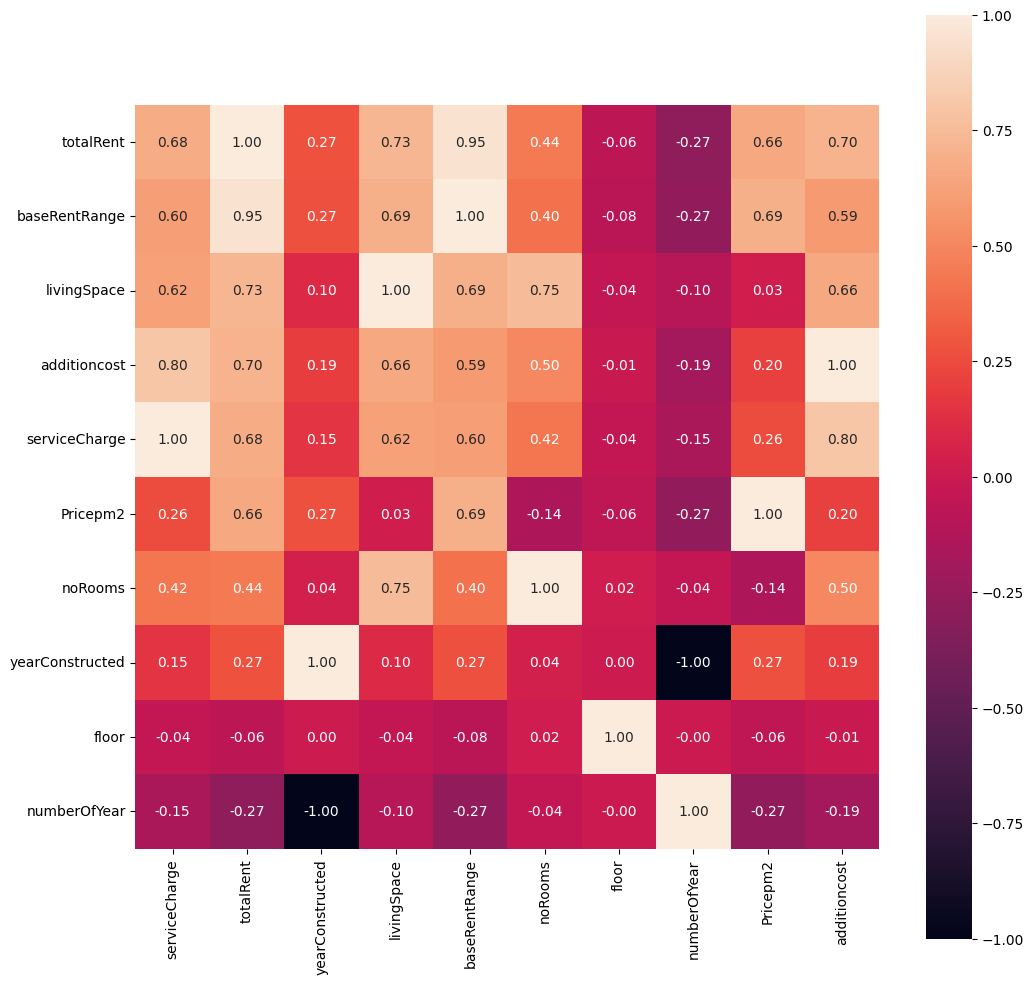

In [178]:
f, ax = plt.subplots(figsize=(12, 12))

sns.heatmap(corr_matrix.sort_values(by='totalRent', ascending=False), square=True, fmt='.2f', annot=True)


<ipython-input-179-dc0f2c8cd959>:2: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




<Axes: xlabel='totalRent', ylabel='Density'>

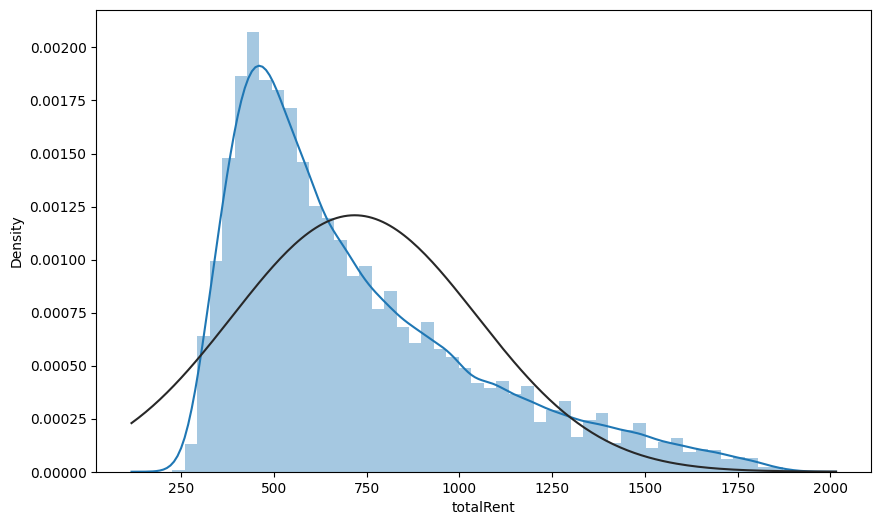

In [179]:
fig,ax = plt.subplots(figsize=(10,6))
sns.distplot(df['totalRent'],fit=norm)

## Predict with ML

In [180]:
predict_df = df.copy()
predict_df.head()

serviceCharge      heatingType  newlyConst  balcony  totalRent  \
101871          150.0  central_heating        True    False     1590.0   
103279          160.0  central_heating       False     True     1355.0   
258844          160.0      oil_heating       False     True     1035.0   
219960          220.0        heat_pump        True     True     1200.0   
223593          200.0  central_heating       False     True     1500.0   

        yearConstructed  hasKitchen  cellar  livingSpace        condition  \
101871           2019.0       False    True         80.0   first_time_use   
103279           1952.0        True    True         59.0  fully_renovated   
258844           1971.0        True    True         75.0        well_kept   
219960           2018.0       False    True        102.0   first_time_use   
223593           1890.0       False   False         85.0   mint_condition   

         lift  baseRentRange   typeOfFlat  noRooms  floor  garden  \
101871   True              7    apartment      3.0    2.0   False   
103279  False              7    apartment      2.0    3.0   False   
258844  False              6    apartment      2.0    1.0   False   
219960   True              6  roof_storey      4.0    2.0   False   
223593   True              7  roof_storey      2.0    3.0   False   

                   regio2  numberOfYear   Pricepm2  additioncost  
101871         Düsseldorf           6.0  18.000000         150.0  
103279  Frankfurt_am_Main          73.0  20.254237         160.0  
258844              Other          54.0  11.666667         160.0  
219960              Other           7.0   9.607843         220.0  
223593              Other         135.0  15.294118         200.0

In [181]:
len(df)

59517

In [182]:
predict_df.drop(columns=['yearConstructed'],inplace=True)


In [183]:
for cols in predict_df.columns:
    if predict_df[cols].dtype == 'int64' or predict_df[cols].dtype == 'float64':
        if cols != 'totalRent':
            predict_df[cols] = ((predict_df[cols] - predict_df[cols].mean())/(predict_df[cols].std()))

predict_df

serviceCharge                     heatingType  newlyConst  balcony  \
101871       0.130913                 central_heating        True    False   
103279       0.293933                 central_heating       False     True   
258844       0.293933                     oil_heating       False     True   
219960       1.272050                       heat_pump        True     True   
223593       0.946011                 central_heating       False     True   
...               ...                             ...         ...      ...   
40487       -0.358146                 central_heating       False     True   
148783      -1.254753  self_contained_central_heating       False    False   
11986       -0.684185                 central_heating       False     True   
247740      -0.521165                 central_heating       False     True   
141446      -1.010224                 central_heating       False    False   

        totalRent  hasKitchen  cellar  livingSpace        condition   lift  \
101871     1590.0       False    True     0.455874   first_time_use   True   
103279     1355.0        True    True    -0.483072  fully_renovated  False   
258844     1035.0        True    True     0.232316        well_kept  False   
219960     1200.0       False    True     1.439533   first_time_use   True   
223593     1500.0       False   False     0.679433   mint_condition   True   
...           ...         ...     ...          ...              ...    ...   
40487       515.0       False    True    -0.214802        well_kept  False   
148783      335.0        True   False    -1.243172        well_kept  False   
11986       800.0        True    True    -1.153748        well_kept   True   
247740      380.0       False   False    -0.617207       modernized  False   
141446      850.0        True    True     0.008757   mint_condition  False   

        baseRentRange           typeOfFlat   noRooms     floor  garden  \
101871       1.834579            apartment  0.476875  0.024584   False   
103279       1.834579            apartment -0.703822  0.774538   False   
258844       1.318745            apartment -0.703822 -0.725371   False   
219960       1.318745          roof_storey  1.657572  0.024584   False   
223593       1.834579          roof_storey -0.703822  0.774538   False   
...               ...                  ...       ...       ...     ...   
40487       -0.744591          roof_storey -0.703822  1.524493   False   
148783      -1.260425                other -1.884519 -0.725371   False   
11986        0.802911            apartment -1.884519 -0.725371   False   
247740      -1.260425            apartment -0.703822  0.024584   False   
141446       0.802911  raised_ground_floor  0.476875 -1.475325   False   

                   regio2  numberOfYear  Pricepm2  additioncost  
101871         Düsseldorf     -1.586807  3.270816     -0.241250  
103279  Frankfurt_am_Main      0.381111  4.000628     -0.072686  
258844              Other     -0.176955  1.220391     -0.072686  
219960              Other     -1.557435  0.553844      0.938698  
223593              Other      2.202169  2.394783      0.601570  
...                   ...           ...       ...           ...  
40487               Essen     -0.940625 -0.589296     -0.746942  
148783              Other      0.058020 -0.591075     -1.421198  
11986          Düsseldorf     -0.059468  2.593881     -1.084070  
247740              Other      1.614731 -0.995764     -0.915506  
141446              Other     -1.469319  0.449555      0.601570  

[59517 rows x 19 columns]

In [184]:
columns = []
for cols in predict_df.columns:
    if predict_df[cols].dtype == 'object' or predict_df[cols].dtype == 'bool':
        columns.append(cols)

dummies_feature = pd.get_dummies(predict_df[columns])
dummies_feature.head()

newlyConst  balcony  hasKitchen  cellar   lift  garden  \
101871        True    False       False    True   True   False   
103279       False     True        True    True  False   False   
258844       False     True        True    True  False   False   
219960        True     True       False    True   True   False   
223593       False     True       False   False   True   False   

        heatingType_central_heating  \
101871                         True   
103279                         True   
258844                        False   
219960                        False   
223593                         True   

        heatingType_combined_heat_and_power_plant  \
101871                                      False   
103279                                      False   
258844                                      False   
219960                                      False   
223593                                      False   

        heatingType_district_heating  heatingType_floor_heating  ...  \
101871                         False                      False  ...   
103279                         False                      False  ...   
258844                         False                      False  ...   
219960                         False                      False  ...   
223593                         False                      False  ...   

        regio2_Köln  regio2_Leipzig  regio2_Leipzig_Kreis  regio2_Magdeburg  \
101871        False           False                 False             False   
103279        False           False                 False             False   
258844        False           False                 False             False   
219960        False           False                 False             False   
223593        False           False                 False             False   

        regio2_Mittelsachsen_Kreis  regio2_München  regio2_Other  \
101871                       False           False         False   
103279                       False           False         False   
258844                       False           False          True   
219960                       False           False          True   
223593                       False           False          True   

        regio2_Recklinghausen_Kreis  regio2_Zwickau  regio2_Zwickau_Kreis  
101871                        False           False                 False  
103279                        False           False                 False  
258844                        False           False                 False  
219960                        False           False                 False  
223593                        False           False                 False  

[5 rows x 55 columns]

In [185]:
predict_df = pd.concat([predict_df, dummies_feature], axis=1)
predict_df = predict_df.drop(columns=columns)
predict_df.head()

serviceCharge  totalRent  livingSpace  baseRentRange   noRooms  \
101871       0.130913     1590.0     0.455874       1.834579  0.476875   
103279       0.293933     1355.0    -0.483072       1.834579 -0.703822   
258844       0.293933     1035.0     0.232316       1.318745 -0.703822   
219960       1.272050     1200.0     1.439533       1.318745  1.657572   
223593       0.946011     1500.0     0.679433       1.834579 -0.703822   

           floor  numberOfYear  Pricepm2  additioncost  \
101871  0.024584     -1.586807  3.270816     -0.241250   
103279  0.774538      0.381111  4.000628     -0.072686   
258844 -0.725371     -0.176955  1.220391     -0.072686   
219960  0.024584     -1.557435  0.553844      0.938698   
223593  0.774538      2.202169  2.394783      0.601570   

        heatingType_central_heating  ...  regio2_Köln  regio2_Leipzig  \
101871                         True  ...        False           False   
103279                         True  ...        False           False   
258844                        False  ...        False           False   
219960                        False  ...        False           False   
223593                         True  ...        False           False   

        regio2_Leipzig_Kreis  regio2_Magdeburg  regio2_Mittelsachsen_Kreis  \
101871                 False             False                       False   
103279                 False             False                       False   
258844                 False             False                       False   
219960                 False             False                       False   
223593                 False             False                       False   

        regio2_München  regio2_Other  regio2_Recklinghausen_Kreis  \
101871           False         False                        False   
103279           False         False                        False   
258844           False          True                        False   
219960           False          True                        False   
223593           False          True                        False   

        regio2_Zwickau  regio2_Zwickau_Kreis  
101871           False                 False  
103279           False                 False  
258844           False                 False  
219960           False                 False  
223593           False                 False  

[5 rows x 58 columns]

In [186]:
move = predict_df['totalRent']
predict_df.drop(labels=['totalRent'], axis=1,inplace = True)
predict_df.insert(0, 'totalRent', move)
predict_df.head()

totalRent  serviceCharge  livingSpace  baseRentRange   noRooms  \
101871     1590.0       0.130913     0.455874       1.834579  0.476875   
103279     1355.0       0.293933    -0.483072       1.834579 -0.703822   
258844     1035.0       0.293933     0.232316       1.318745 -0.703822   
219960     1200.0       1.272050     1.439533       1.318745  1.657572   
223593     1500.0       0.946011     0.679433       1.834579 -0.703822   

           floor  numberOfYear  Pricepm2  additioncost  \
101871  0.024584     -1.586807  3.270816     -0.241250   
103279  0.774538      0.381111  4.000628     -0.072686   
258844 -0.725371     -0.176955  1.220391     -0.072686   
219960  0.024584     -1.557435  0.553844      0.938698   
223593  0.774538      2.202169  2.394783      0.601570   

        heatingType_central_heating  ...  regio2_Köln  regio2_Leipzig  \
101871                         True  ...        False           False   
103279                         True  ...        False           False   
258844                        False  ...        False           False   
219960                        False  ...        False           False   
223593                         True  ...        False           False   

        regio2_Leipzig_Kreis  regio2_Magdeburg  regio2_Mittelsachsen_Kreis  \
101871                 False             False                       False   
103279                 False             False                       False   
258844                 False             False                       False   
219960                 False             False                       False   
223593                 False             False                       False   

        regio2_München  regio2_Other  regio2_Recklinghausen_Kreis  \
101871           False         False                        False   
103279           False         False                        False   
258844           False          True                        False   
219960           False          True                        False   
223593           False          True                        False   

        regio2_Zwickau  regio2_Zwickau_Kreis  
101871           False                 False  
103279           False                 False  
258844           False                 False  
219960           False                 False  
223593           False                 False  

[5 rows x 58 columns]

In [187]:
X = predict_df.iloc[:,1:].values # Select all the columns, that's not totalRent
y = predict_df.iloc[:,0].values # Select only totalRent

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 123)

In [188]:
d_train = lgb.Dataset(x_train, label=y_train) # Load the dataset and test

# parameters for this model
params = {
        'n_estimators': 10000,
        'objective': 'regression',
        'metric': 'rmse',
        'boosting_type': 'gbdt',
        'max_depth': -1,
        'learning_rate': 0.01,
        'subsample': 0.72,
        'subsample_freq': 4,
        'feature_fraction': 0.4,
        'lambda_l1': 1,
        'lambda_l2': 1,
        'seed': 46,
        }

clf = lgb.train(params, d_train, 100)

/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning:

Found `n_estimators` in params. Will use it instead of argument



[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005715 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1306
[LightGBM] [Info] Number of data points in the train set: 44637, number of used features: 57
[LightGBM] [Info] Start training from score 718.319066


In [189]:
y_pred = clf.predict(x_test)
y_pred

array([ 484.9477349 ,  340.4989381 ,  486.05744526, ..., 1037.2589443 ,
        669.0722667 ,  350.25158158])

In [190]:
def compute_rmse(model, X, y_true, name):
    y_pred = model.predict(X)
    mse = mean_squared_error(y_true, y_pred)
    rmse = pow(mse,0.5)
    print(f'Root Mean Squared Error for {name}: {rmse}')

In [191]:
compute_rmse(clf, x_train, y_train, 'Training Set')
compute_rmse(clf, x_test, y_test, 'Test Set')

Root Mean Squared Error for Training Set: 5.094973596591126
Root Mean Squared Error for Test Set: 7.671797782881941


In [194]:
clf.save_model('model.txt')

In [195]:
from google.colab import files
files.download('model.txt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [196]:
predict_df.columns

Index(['totalRent', 'serviceCharge', 'livingSpace', 'baseRentRange', 'noRooms',
       'floor', 'numberOfYear', 'Pricepm2', 'additioncost',
       'heatingType_central_heating',
       'heatingType_combined_heat_and_power_plant',
       'heatingType_district_heating', 'heatingType_floor_heating',
       'heatingType_gas_heating', 'heatingType_heat_pump',
       'heatingType_night_storage_heater', 'heatingType_oil_heating',
       'heatingType_self_contained_central_heating',
       'heatingType_wood_pellet_heating', 'condition_Other',
       'condition_first_time_use',
       'condition_first_time_use_after_refurbishment',
       'condition_fully_renovated', 'condition_mint_condition',
       'condition_modernized', 'condition_refurbished', 'condition_well_kept',
       'typeOfFlat_apartment', 'typeOfFlat_ground_floor',
       'typeOfFlat_half_basement', 'typeOfFlat_loft', 'typeOfFlat_maisonette',
       'typeOfFlat_other', 'typeOfFlat_penthouse',
       'typeOfFlat_raised_ground_floor